#### author: Claudia Acquistapace
#### goal: figure for Agostino plot of SST, PBLH, LCL, CBH da lidar

#### date: 11/02/2022


In [2]:
# importing necessary libraries
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib
import numpy as np
import xarray as xr
from datetime import datetime
import matplotlib.dates as mdates
import glob
#from myFunctions import lcl
#from myFunctions import f_closest
from warnings import warn
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from scipy import interpolate
import custom_color_palette as ccp
from matplotlib import rcParams
import matplotlib.ticker as ticker
import matplotlib.font_manager as font_manager

# read SST temperature
# reading tsg file ( data with 1 min resolution)
tsg_file = "/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/tsg_sst_data/tsg/nc/msm_089_1_tsg.nc"

tsg_data = xr.open_dataset(tsg_file)

# identifying time stamps of sst corresponding to time stamps of radiosondes
t_start = datetime(2020, 2, 2, 0, 0, 0)
t_end = datetime(2020, 2, 3, 23, 59, 59)

# slicing tsg datase t for the selected time interval and extracting sst
sliced_tsg_ds = tsg_data.sel(TIME=slice(t_start, t_end))
tsg_sst = sliced_tsg_ds['TEMP'].values
tsg_time_sst = sliced_tsg_ds['TIME'].values
tsg_flag = sliced_tsg_ds['TEMP_QC'].values

# averaging together the sst of the different sst sensors for tsg
temp0 = sliced_tsg_ds.TEMP[:,0].values
temp1 = sliced_tsg_ds.TEMP[:,1].values
sst_tsg = temp0
sst_tsg[np.isnan(temp0)] = temp1[np.isnan(temp0)]

# producing output dataset of sst_tsg for the selected time window
# creating dataset with coordinates sst and height
dim_sst           = ['time']
coords         = {"time":sliced_tsg_ds.TIME.values}
SST              = xr.DataArray(dims=dim_sst, coords=coords, data=sst_tsg,
                 attrs={'long_name':'sea surface temperature ',
                        'units':'$^{\circ}$C'})
variables         = {'SST':SST}
SST_DS      = xr.Dataset(data_vars = variables,
                       coords = coords)

# opening noise mask file to read cloud base
noise_mask_file = '/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/arthus_data/noise_mask.nc'
noise_mask = xr.open_dataset(noise_mask_file)
noise_mask = noise_mask.sel(Time=slice(datetime(2020,2,2,0,0,0), datetime(2020,2,3,23,59,59)))
cloud_base = noise_mask.cloud_base_height.values


# opening data and thermodynamic properties derived from radiosondes
rs_vars_file = '/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/post_processed_data/thermodyn_properties_RS.nc'
rs_dataset = xr.open_dataset(rs_vars_file)



In [26]:
# atl: R/V Atalante, mer: R/V Maria S. Merian, met: R/V Meteor, rhb: Ron H. Brown, bco: Barbados Cloud Observatory.
rootdir = '/Volumes/Extreme SSD/Downloads/'
# Paths to QC TSG: Quality Check ThermoSalinoGraph.
path2atlQCTSG = '/Users/claudia/Downloads/'


# Read the Atalante QC TSG data.
filename_dat = path2atlQCTSG + 'Atalante_traj_gosud3_2001-18022020-cor'

# Read the dat file.
ndf = pd.read_csv(filename_dat, delimiter='\s+', header=None, engine='python',
                  names=['year','month','day','hour','minute','second', 'lon', 'lat', 'salt', 'temp', 'bho'])

df = pd.DataFrame({'year': ndf.year,
                   'month': ndf.month,
                   'day': ndf.day,
                   'hour': ndf.hour,
                   'minute': ndf.minute,
                   'second': ndf.second})


time_atlqctsg = pd.to_datetime(df)
lon_atlqctsg = ndf.lon
lat_atlqctsg = ndf.lat

# Remove the outliers.
temp_atlqctsg = ndf.temp
temp_atlqctsg[ndf.temp>28] = np.NaN

# Define the time window of interest YYYY-MM-DD
datestr_start = '2020-02-02'
datestr_end = '2020-02-04'
date_start = np.datetime64(datestr_start)
date_end = np.datetime64(datestr_end)
idtime_atlqctsg = (time_atlqctsg>date_start) & (time_atlqctsg<date_end)


/var/folders/vq/pfv4n2796kvc782gmx0q4bhc0000gn/T/ipykernel_7799/3881584644.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_atlqctsg[ndf.temp>28] = np.NaN


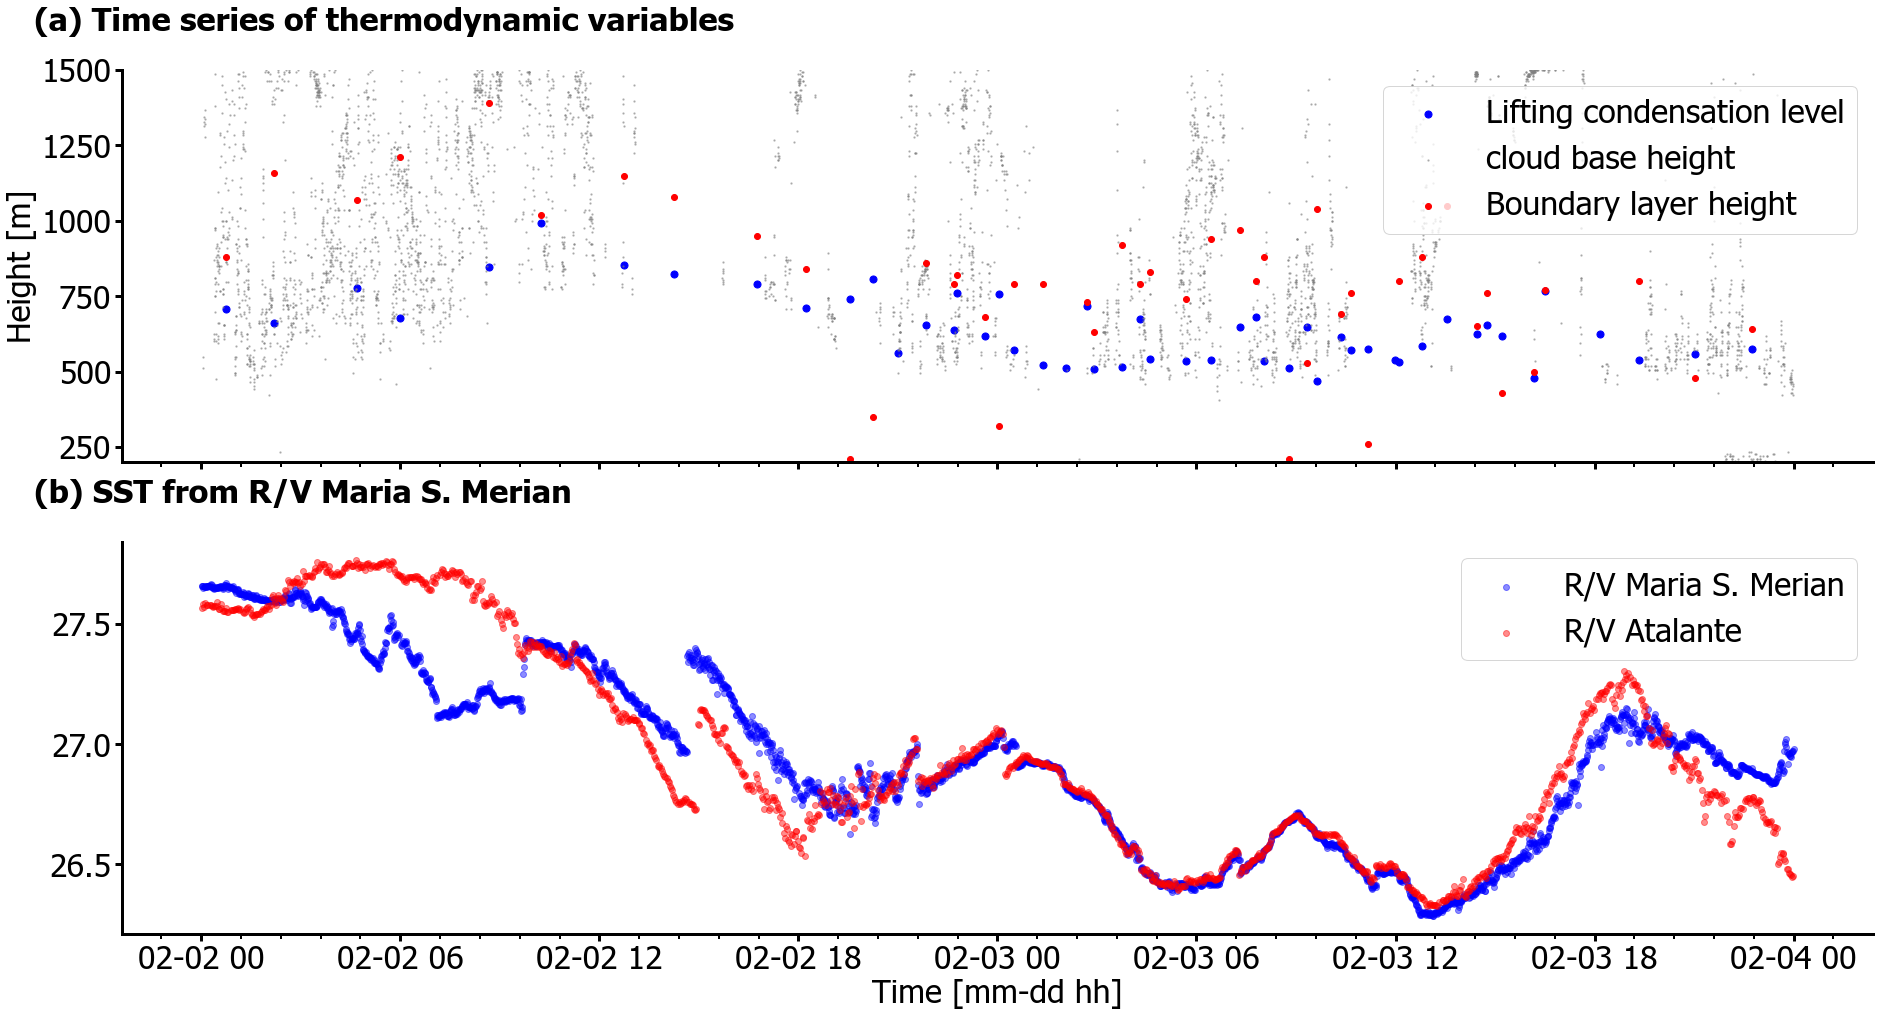

In [31]:
dict_plot_settings = {
    'labelsizeaxes':32,
    'fontSizeTitle':32,
    'fontSizeX'    :32,
    'fontSizeY'    :32,
    'cbarAspect'   :15,
    'fontSizeCbar' :32,
    'rcparams_font':['Tahoma'],
    'savefig_dpi'  :100,
    'font_size'    :32, 
    'grid'         :True, 
    'plot_ticks'   :18}

# composite figure variables binned in sst 
path_out_plots = '/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/SST_impact_work/plots/'

# plots settings defined by user at the top
labelsizeaxes   = dict_plot_settings['labelsizeaxes']
fontSizeTitle   = dict_plot_settings['fontSizeTitle']
fontSizeX       = dict_plot_settings['fontSizeX']
fontSizeY       = dict_plot_settings['fontSizeY']
cbarAspect      = dict_plot_settings['cbarAspect']
fontSizeCbar    = dict_plot_settings['fontSizeCbar']
rcParams['font.sans-serif'] = dict_plot_settings['rcparams_font']
matplotlib.rcParams['savefig.dpi'] = dict_plot_settings['savefig_dpi']
plt.rcParams.update({'font.size':dict_plot_settings['font_size']})
grid = dict_plot_settings['grid']
matplotlib.rc('xtick', labelsize=dict_plot_settings['plot_ticks'])  # sets dimension of ticks in the plots
matplotlib.rc('ytick', labelsize=dict_plot_settings['plot_ticks'])  # sets dimension of ticks in the plots

fig, axs = plt.subplots(2,1, figsize=(26,14), sharex=True, constrained_layout=True)

axs[0].scatter(rs_dataset.time.values, rs_dataset.lcl.values, label='Lifting condensation level', s=50., color='blue')
axs[0].scatter(noise_mask.Time.values, cloud_base, color='grey', label='cloud base height', s=2., alpha=0.45)
axs[0].scatter(rs_dataset.time.values, rs_dataset.pblh.values, label='Boundary layer height', color='red')
axs[0].set_ylabel('Height [m]', fontsize=fontSizeX)
axs[0].set_ylim(200.,1500.)
axs[0].legend(frameon=True)
axs[1].scatter(SST_DS.time.values, SST_DS.SST.values, color='blue', alpha=0.45, label='R/V Maria S. Merian')
axs[1].set_xlabel('Time [mm-dd hh]', fontsize=fontSizeX)
axs[1].scatter(time_atlqctsg[idtime_atlqctsg],temp_atlqctsg[idtime_atlqctsg],color='red', alpha=0.45, label='R/V Atalante')
axs[1].legend(frameon=True)

for ax, l in zip(axs[:].flatten(), ['(a) Time series of thermodynamic variables', \
                                    '(b) SST from R/V Maria S. Merian']):
    ax.text(-0.05, 1.1, l,  fontweight='black', fontsize=fontSizeX, transform=ax.transAxes)
    #ax.set_xlim(SST_binned_arr[0]-0.1, SST_binned_arr[-1]+0.1)
    
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_linewidth(3)
    ax.spines["left"].set_linewidth(3)
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(n=5))
    ax.tick_params(which='minor', length=5, width=2)
    ax.tick_params(which='major', length=7, width=3)
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(n=5))
    ax.tick_params(axis='both', labelsize=32)
fig.savefig(path_out_plots+'thermodyn_RS_timeseries.png', format='png')
